# Open Loop

[A1 - First trial selection](#A1)

[A3 - Order of presentation during training](#A3)

[A4 - Performance during training](#A4)

[A5 - Learning Progress](#A5)

[A6 - Relative performance during training](#A6)

[A7 - Relative Learning Progress](#A7)

## Set-up and Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import pandas as pd
import warnings
#import seaborn as sns
from scipy.stats import beta

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=2)

import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Load per trial data files

In [2]:
execute_notebook("Preprocessing.ipynb")

['free']
99
['free', 'train']
['free', 'test', 'train']


In [3]:
tasks = 4
catLab = ['1D', 'I1D', '2D', 'R']

usersF = np.shape(np.unique(csvIntF[:,0]))[0]
# For free exploration with Training
usersFT = np.shape(np.unique(csvIntFT[:,0]))[0]
usersFTI = np.shape(np.unique(informed[:,0]))[0]
usersFTU = usersFT-usersFTI
# For strategic learning
usersS = np.shape(np.unique(csvIntS[:,0]))[0]
usersSI = np.shape(np.unique(informedSE[:,0]))[0]
usersSU = usersS-usersSI

#### Load combined data

In [4]:
execute_notebook("Preprocessing-Stack Data.ipynb")

"\n#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(7:12)\nfree = np.loadtxt('../generated-data/free-free.txt')\nprint('Free Exploration - general metrics loaded')\n"

[  0.     0.     1.    16.     0.06  14.     0.88   3.     3.     3.     6.
  10.     6.     2.    11.     0.73]
Free Exploration with Training - general metrics loaded
Strategic Learning - general metrics loaded


#### Split by information (free exp with training)

In [5]:
#user(0), cond(1) cat-task complexity(2), # task selec(3), % sele(4), # correct on task(5), % correct(6), 
#answers(7:12)

# Split by users that received information about the existence of a random task and those that didn't
informedFT = freeT[freeT[:,1]==0]
uninformedFT = freeT[freeT[:,1]==1]
#print(spilot[-1,:])
# Remove first column 
freeT = np.delete(freeT, 1, axis=1)
informedFT = np.delete(informedFT, 1, axis=1)
uninformedFT = np.delete(uninformedFT, 1, axis=1)
#free = np.delete(free, 1, axis=1)

#### Split by information (strategic learning)

In [6]:
# Split by users that received information about the existence of a random task and those that didn't
informedS = stra[stra[:,1]==0]
uninformedS = stra[stra[:,1]==1]
#print(spilot[-1,:])
# Remove column (condition)
stra = np.delete(stra, 1, axis=1)
informedS = np.delete(informedS, 1, axis=1)
uninformedS = np.delete(uninformedS, 1, axis=1)

<a id='A1'></a>
## A1 - First trial selection

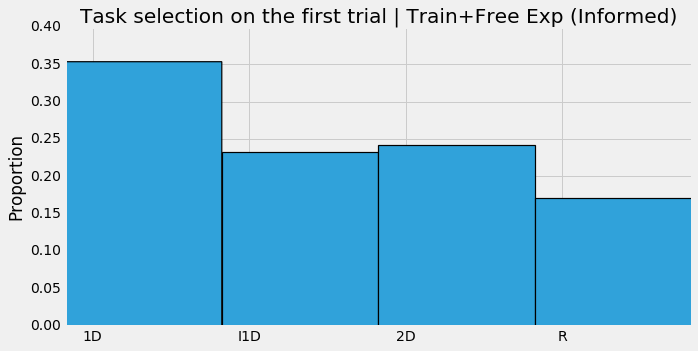

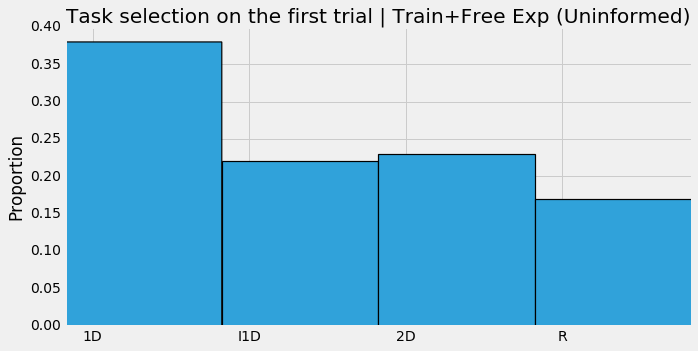

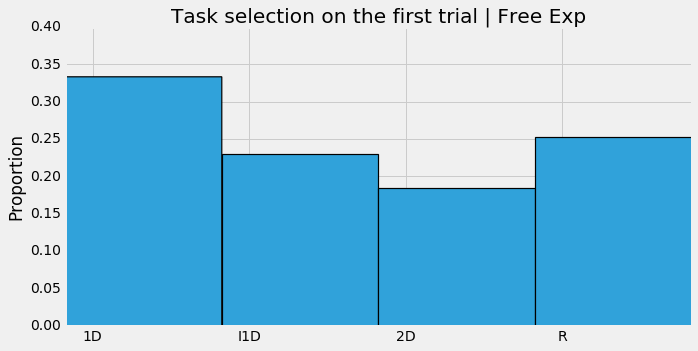

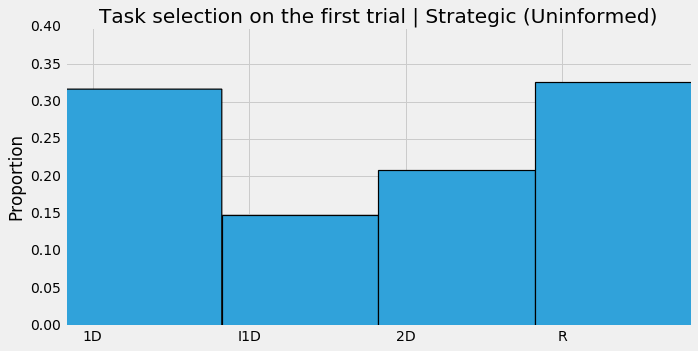

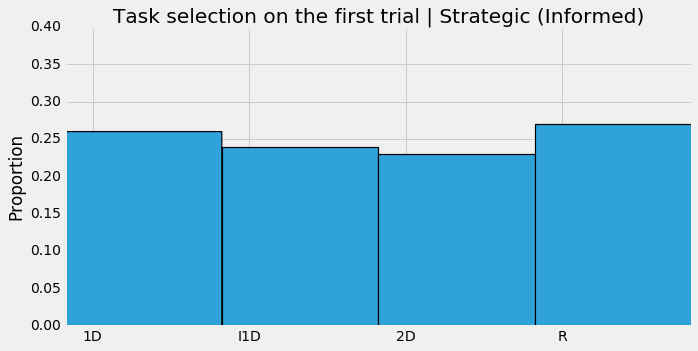

In [7]:
def checkFirstOption(arr, usersArr, checkIncomplete=False):
    firstSelec = []
    incomplete = []
    for u in range(usersArr):
        # If it's necessary to check those that didn't explore all tasks (e.g. free exploration only)
        if checkIncomplete:
            questions = arr[u]
            # Count number of times a task was selected
            task, ctask = np.unique(questions[:,1], return_counts=True)

            # Check if it explored all tasks
            if len(task) < 4:
                incomplete.append(u)
            else:
                firstSelec.append(arr[u][0,1])
        else:
            firstSelec.append(arr[u][0,1])
            
    # Return also a list of people who didn't explore all tasks
    return np.asarray(firstSelec), incomplete
    
def plotFirstOption(arr, usersArr, label, checkIncomplete=False):
    firstSelec, _ = checkFirstOption(arr, usersArr, checkIncomplete)
    ind = np.arange(tasks)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(firstSelec, bins=np.arange(5), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial | ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))
    ax.set_ylim([0,0.4])

#plotFirstOption(splitCsvFTE, usersFT, 'Train+Free Exp (All)')

plotFirstOption(splitCsvFTI, usersFTI, 'Train+Free Exp (Informed)')
plotFirstOption(splitCsvFTU, usersFTU, 'Train+Free Exp (Uninformed)')
plotFirstOption(splitCsvF, usersF, 'Free Exp', checkIncomplete=True)
plotFirstOption(splitCsvSU, usersSU, 'Strategic (Uninformed)')
plotFirstOption(splitCsvSI, usersSI, 'Strategic (Informed)')


<a id='A3'></a>
## A3 - Order of presentation during training

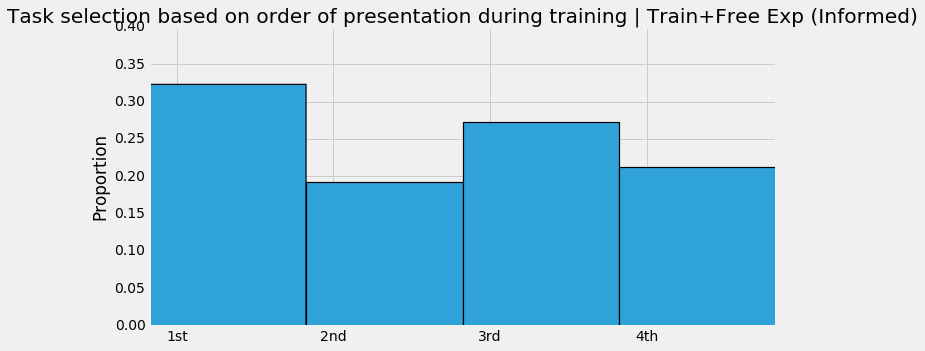

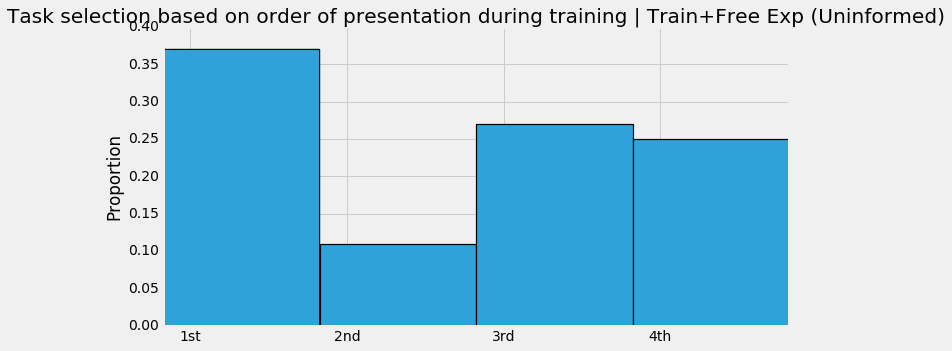

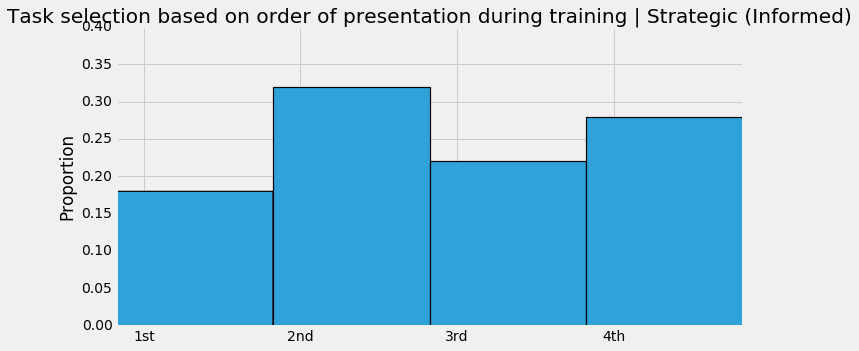

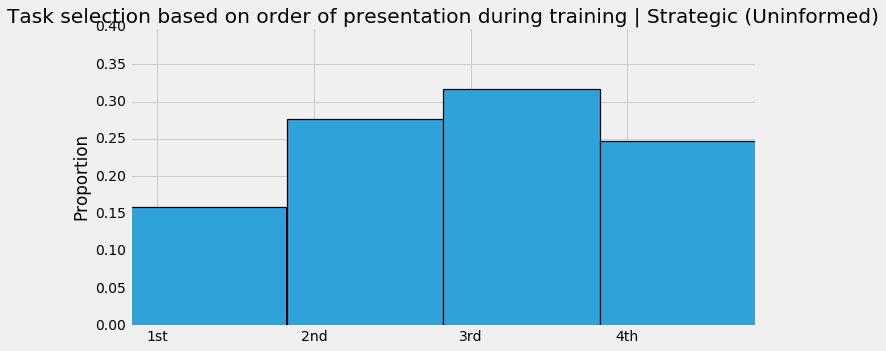

In [8]:
#A3. Order of presentation during training: % ppl who selected the first task they saw during training, 
#the 2nd task, the 3rd, and the 4th. We may see a uniform distributions, or peaks at 1 and 4. 

#ids, informed, phases, categories, correct
# Split by informed or uninformed
a3FTI = csvIntFT[csvIntFT[:,1] == 0,:]
a3FTU = csvIntFT[csvIntFT[:,1] == 1,:]
# Split by user
splita3FTI = [a3FTI[a3FTI[:,0]==i] for i in np.unique(a3FTI[:,0])]
splita3FTU = [a3FTU[a3FTU[:,0]==i] for i in np.unique(a3FTU[:,0])]

a3SI = csvIntS[csvIntS[:,1] == 0,:]
a3SU = csvIntS[csvIntS[:,1] == 1,:]
# Split by user
splita3SI = [a3SI[a3SI[:,0]==i] for i in np.unique(a3SI[:,0])]
splita3SU = [a3SU[a3SU[:,0]==i] for i in np.unique(a3SU[:,0])]

def getFirstSelecOrder(arr, usersArr, strategic=False):
    if strategic:
        trVal = 2
    else:
        trVal = 1
    orderSelec = []
    for u in range(usersArr):
        tmp = arr[u]
        # Get only training part
        # for strategic learning this should be 2
        tmpPhase = tmp[tmp[:,2] == trVal,:]
        # Pass task column and get order indices then get order
        orderIndex = np.unique(tmpPhase[:,3], return_index=True)[1]
        orderTaskUser = [tmpPhase[ind, 3] for ind in sorted(orderIndex)]
        # Get only exploration part
        tmpPhase = tmp[tmp[:,2] == 0,:]
        firstSelec = tmpPhase[0,3]
        # Match that first selection to the order in which it showed up during training
        orderTrain = np.where(orderTaskUser == firstSelec)[0][0]
        #print(orderTaskUser, firstSelec, orderTrain)
        orderSelec.append(orderTrain)
    return orderSelec

def plotFirstSelecOrder(arr, usersArr, label, strategic=False):
    orderSelec = getFirstSelecOrder(arr, usersArr, strategic)
    #print(np.shape(orderSelec), orderSelec)
    
    ind = np.arange(tasks)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(orderSelec, bins=np.arange(5), normed=True, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection based on order of presentation during training | ', label]))
    ax.set_ylabel('Proportion')
    #ax.set_xlabel('t')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1st', '2nd', '3rd', '4th'))
    ax.set_ylim([0,0.4])

plotFirstSelecOrder(splita3FTI, usersFTI, 'Train+Free Exp (Informed)')
plotFirstSelecOrder(splita3FTU, usersFTU, 'Train+Free Exp (Uninformed)')
plotFirstSelecOrder(splita3SI, usersSI, 'Strategic (Informed)')
plotFirstSelecOrder(splita3SU, usersSU, 'Strategic (Uninformed)')

<a id='A4'></a>
## A4 - Performance during training

In [9]:
#A4. Performance during training: calculate %correct during the 15 training trials, bin the percentages, 
#and plot the % of ppl who selected a task with the PC in each bin. 

#user(0), cat-task complexity(1), # task selec(2), % sele(3), # correct on task(4), % correct(5), answers(6:11)
# # correct (5), % clection according to the order of presentation during trainingorrect (6)

# Split those informed and those uninformed. (col 1)
ift = freeTTr[freeTTr[:,1]==0,:]
uft = freeTTr[freeTTr[:,1]==1,:]
istr = straTr[straTr[:,1]==0,:]
ustr = straTr[straTr[:,1]==1,:]

# Get task first selections
selFTI = checkFirstOption(splitCsvFTI, usersFTI)
selFTU = checkFirstOption(splitCsvFTU, usersFTU)
selSI = checkFirstOption(splitCsvSI, usersSI)
selSU = checkFirstOption(splitCsvSU, usersSU)

# Get training pc of the first task selected
def checkPerformance(arr, firstSelec):
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    pcTrain = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only % correct of the row that corresponds to first selection
        tmprow = sub[sub[:,2] == firstSelec[0].tolist()[u],6]
        pcTrain.append(tmprow[0])
    return pcTrain

def plotPerformance(arr, firstSelec, label):
    
    performance = checkPerformance(arr, firstSelec)
    
    # Create bins (0 - 1 in 0.1 steps)
    binsPC = np.linspace(0,1.1,12)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    plt.hist(performance, bins=binsPC, weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt PC | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_ylim([0,0.32])

        
# Verification
plotPerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotPerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotPerformance(istr,selSI, 'Strategic (Informed)')
plotPerformance(ustr,selSU, 'Strategic (Uninformed)')

IndexError: list index out of range

<a id='A6'></a>
## A6 - Relative performance during training

In [10]:
#A6. Relative performance during training: for each participant, take the value representing the PC for 
#each task during training, and normalize it by the mean PC across all 4 tasks. Plot the % of ppl who 
#selected a task as a function of its normalized PC.

# Get relative training pc of the first task selected
def checkRelativePerformance(arr, firstSelec):
    usersArr = len(np.unique(arr[:,0]))
    # Split by user
    splitArr = [arr[arr[:,0]==i] for i in np.unique(arr[:,0])]
    # Stores percentage correct during training of the task that later on was selected first on free exploration
    # Normalized
    pcTrain = []
    # Go through every user and only extract the PC of the first task selected
    for u in range(usersArr):
        sub = splitArr[u]
        # get only % correct of the row that corresponds to first selection
        tmprow = sub[sub[:,2] == firstSelec[0].tolist()[u],6]
        # get % correct of all tasks and calculate mean
        pcNorm = np.mean(sub[:,6])
        # Append normalized pc
        pcTrain.append(tmprow[0]/pcNorm)
    return pcTrain

def plotRelativePerformance(arr, firstSelec, label):
    
    performance = checkRelativePerformance(arr, firstSelec)
    
    # Create bins (0 - 1 in 0.1 steps)
    binsPC = np.linspace(0,2.1,22)
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(performance)/len(performance)
    plt.hist(performance, bins=binsPC, weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt relative PC | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_ylim([0,0.2])
    
plotRelativePerformance(ift,selFTI, 'Train+Free Exp (Informed)')
plotRelativePerformance(uft,selFTU, 'Train+Free Exp (Uninformed)')
plotRelativePerformance(istr,selSI, 'Strategic (Informed)')
plotRelativePerformance(ustr,selSU, 'Strategic (Uninformed)')

IndexError: list index out of range

<a id='A5'></a>
## A5 - Learning Progress

#### Additional Preprocessing (Free Exploration with Training)

In [15]:
# Load behavioral trajectories (csvIntFT)
# Get only those in training phase
csvIntFTT = csvIntFT[csvIntFT[:,2]==1]
# Get a copy for splitting by condition (below)
csvIntFTTCond = csvIntFTT.copy()

# Remove phase column (2) (and for now also the condition column (1))
csvIntFTT = np.delete(csvIntFTT, (1,2), axis=1)

# Split by condition
# Get rid of phase column
csvIntFTTCond = np.delete(csvIntFTTCond, 2, axis = 1)
# Split by informed/uninformed
informedFTT = csvIntFTTCond[csvIntFTTCond[:,1]==0]
uninformedFTT = csvIntFTTCond[csvIntFTTCond[:,1]==1]
informedFTT = np.delete(informedFTT, 1, axis=1)
uninformedFTT = np.delete(uninformedFTT, 1, axis=1)
# Split by user
splitInfFTT = [informedFTT[informedFTT[:,0]==i] for i in np.unique(informedFTT[:,0])]
splitUniFTT = [uninformedFTT[uninformedFTT[:,0]==i] for i in np.unique(uninformedFTT[:,0])]

#### Additional Preprocessing (Strategic)

In [16]:
# Load behavioral trajectories (csvIntFT)
# Get only those in training phase
csvIntST = csvIntS[csvIntS[:,2]==1]
# Get a copy for splitting by condition (below)
csvIntSTCond = csvIntST.copy()

# Remove phase column (2) (and for now also the condition column (1))
csvIntST = np.delete(csvIntST, (1,2), axis=1)

# Split by condition
# Get rid of phase column
csvIntSTCond = np.delete(csvIntSTCond, 2, axis = 1)
# Split by informed/uninformed
informedST = csvIntSTCond[csvIntSTCond[:,1]==0]
uninformedST = csvIntSTCond[csvIntSTCond[:,1]==1]
informedST = np.delete(informedST, 1, axis=1)
uninformedST = np.delete(uninformedST, 1, axis=1)
# Split by user
splitInfST = [informedST[informedST[:,0]==i] for i in np.unique(informedST[:,0])]
splitUniST = [uninformedST[uninformedST[:,0]==i] for i in np.unique(uninformedST[:,0])]

In [17]:
# Gets the p(correct) at each trial per task and per user
def extractProbsTrajec(arr, userArr):
    # Store p(correct) per user
    probUser = []
    # Go through user
    for u in range(userArr):
        tmpU = arr[u]
        # Init prior
        alpha,bet = 2,2
        # Store p(correct) = predicted accuracy evolution per task for user u
        probTask = []
        # Go through each task
        for t in range(tasks):
            # Split by task
            tmpT = tmpU[tmpU[:,1] == t]
            # Go through its trial history
            succ = 0
            # store p(correct) in this task
            probs = []
            probs.append(np.mean(beta(alpha+succ, bet+(0+1)-succ).rvs(size=500)))
            #print(np.mean(beta(alpha+succ, bet+(0+1)-succ).rvs(size=500)), alpha+succ, bet+0-succ)
            for trial in range(np.shape(tmpT)[0]):
                # Check if the answer was correct on this trial
                if tmpT[trial,2] == 1:
                    succ+=1
                #Construct beta distribution for posterior Beta(α=1+Succ, β=1+Trials−Succ)
                dist = beta(alpha+succ, bet+(trial+1)-succ)
                #Draw sample from beta distribution
                #print(np.mean(dist.rvs(size=500)), alpha+succ, bet+(trial+1)-succ)
                probs.append(np.mean(dist.rvs(size=500)))
            probTask.append(probs)
        probUser.append(probTask)
    return np.asarray(probUser)

# Obtain predicted accuracy (e.g. "I predict based on my observations that my p(correct)=? if you ask me 
# to classify instances of this exercise without receiving any feedback")
probsFTTI = extractProbsTrajec(splitInfFTT, usersFTI)
probsFTTU = extractProbsTrajec(splitUniFTT, usersFTU)
probsSTI = extractProbsTrajec(splitInfST, usersSI)
probsSTU = extractProbsTrajec(splitUniST, usersSU)

In [18]:
def getLP(probs, userArr):
    lpsUser = []
    # Go through every user and task
    for u in range(userArr):
        #tmpU = diff[u]
        tmpU = probs[u]
        lps = []
        for t in range(tasks):
            # Convert prob to errors
            errT = 1-tmpU[t]
            # Get err difference |e(t) - e(t-1)|^2
            diffT = np.diff(errT)
            # fit polinomial to error differences
            slope, intercept = np.polyfit(np.arange(len(diffT)), diffT, 1)
            x = np.linspace(0, len(diffT)-1, 100)
            # LP = - [Fitted Error(present) - Fitted Error(past)]
            lp = -((slope*x[-1]+intercept)-(slope*x[0]+intercept))
            lps.append(lp)
            #print(slope*x[0]+intercept, slope*x[-1]+intercept, diffT, lp)
            #print(probs[u], errT, diffT, slope*x[0]+intercept, slope*x[-1]+intercept, lp)
        lpsUser.append(lps)
        
        #print(lpsUser)
    return np.asarray(lpsUser)

# Get LP
lpFTTI = getLP(probsFTTI, usersFTI)
lpFTTU = getLP(probsFTTU, usersFTU)
lpSTI = getLP(probsSTI, usersSI)
lpSTU = getLP(probsSTU, usersSU)
#print(np.shape(lpFTTI), lpFTTI)

# Associate training LP to first selection
fslpFTI = lpFTTI[np.arange(len(lpFTTI)), selFTI[0]]
fslpFTU = lpFTTU[np.arange(len(lpFTTU)), selFTU[0]]
fslpSI = lpSTI[np.arange(len(lpSTI)), selSI[0]]
fslpSU = lpSTU[np.arange(len(lpSTU)), selSU[0]]

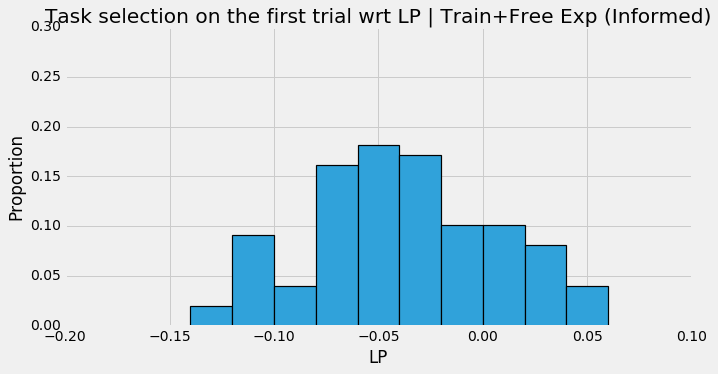

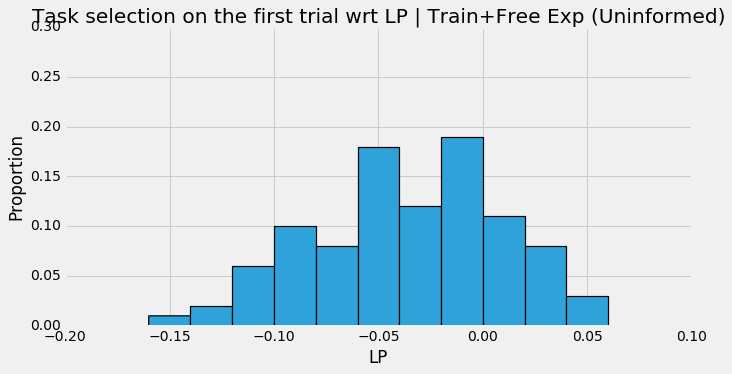

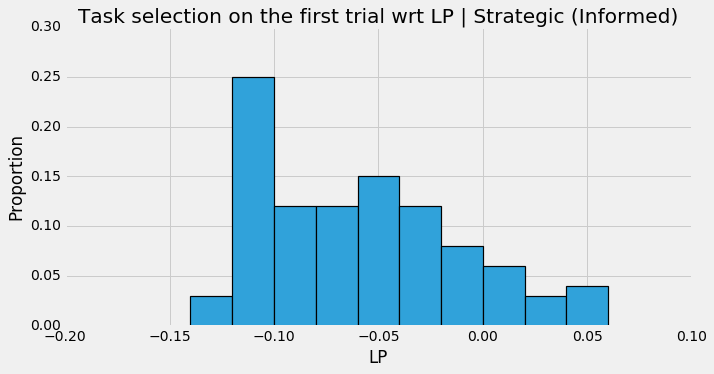

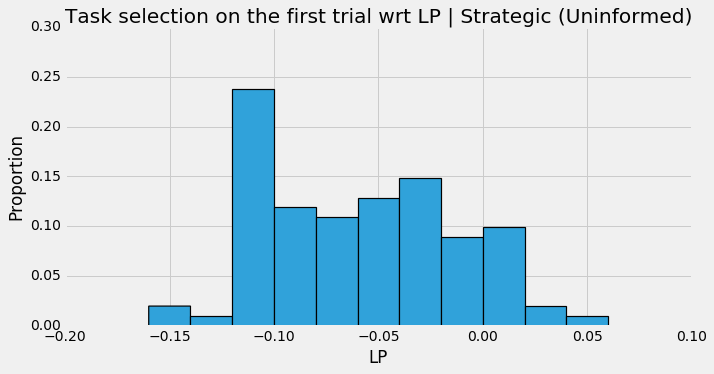

In [19]:
def plotLP(arr, label):
    # Create bins (0 - 0.03 in 0.001 steps)
    binsLP = np.arange(-0.16, 0.08, 0.02) 
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Normalize to sum 1
    weights = np.ones_like(arr)/len(arr)
    plt.hist(arr, bins=binsLP, weights=weights, edgecolor='black', linewidth=1.2)
    #plt.hist(arr, bins=binsLP, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt LP | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_xlabel('LP')
    ax.set_ylim([0,0.3])

plotLP(fslpFTI, 'Train+Free Exp (Informed)')
plotLP(fslpFTU, 'Train+Free Exp (Uninformed)')
plotLP(fslpSI, 'Strategic (Informed)')
plotLP(fslpSU, 'Strategic (Uninformed)')

#### Normal LP

Fits a linear regressor to the error curve

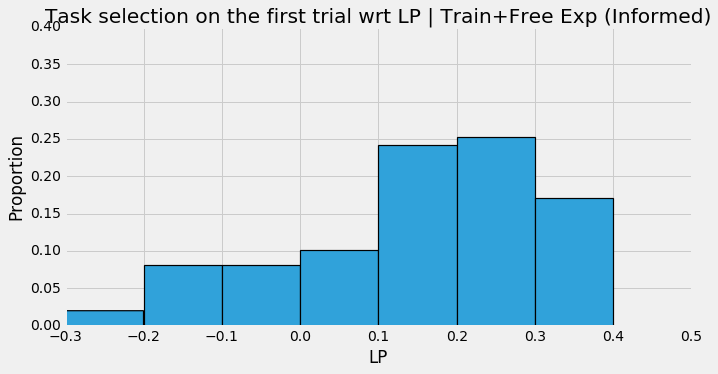

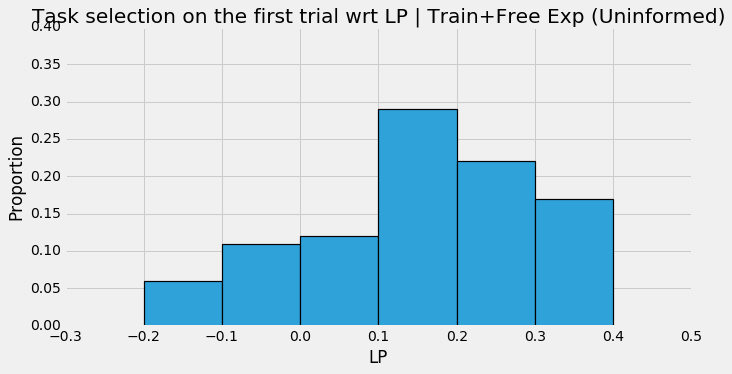

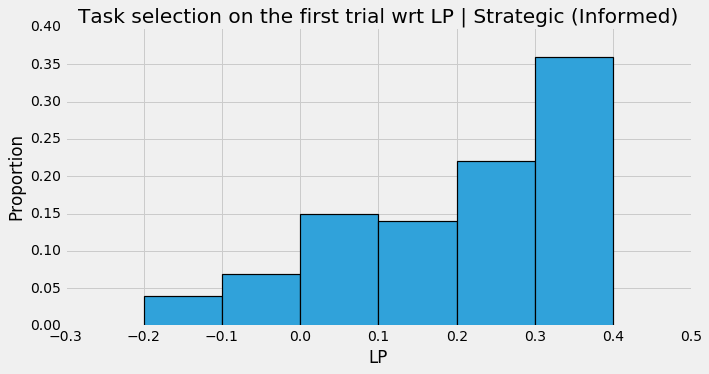

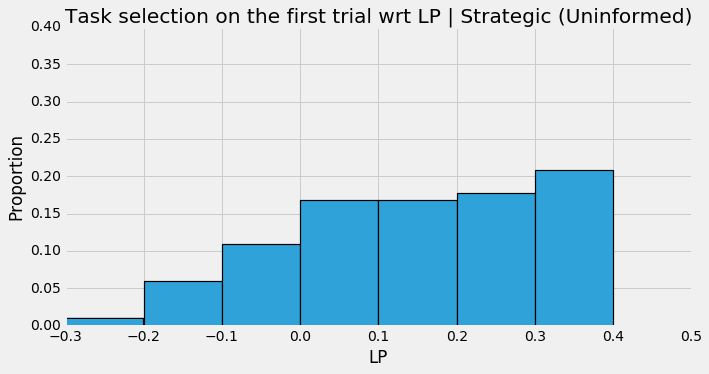

In [20]:
def getLPNormal(probs, userArr):
    lpsUser = []
    # Go through every user and task
    for u in range(userArr):
        #tmpU = diff[u]
        tmpU = probs[u]
        lps = []
        for t in range(tasks):
            # Convert prob to errors
            errT = 1-tmpU[t]
            # fit polinomial to error differences
            slope, intercept = np.polyfit(np.arange(len(errT)), errT, 1)
            x = np.linspace(0, len(errT)-1, 100)
            # LP = - [Fitted Error(present) - Fitted Error(past)]
            lp = -((slope*x[-1]+intercept)-(slope*x[0]+intercept))
            lps.append(lp)
            #print(slope*x[0]+intercept, slope*x[-1]+intercept, diffT, lp)
            #print(probs[u], errT, diffT, slope*x[0]+intercept, slope*x[-1]+intercept, lp)
        lpsUser.append(lps)
        
        #print(lpsUser)
    return np.asarray(lpsUser)

# Get LP
lpFTTI_N = getLPNormal(probsFTTI, usersFTI)
lpFTTU_N = getLPNormal(probsFTTU, usersFTU)
lpSTI_N = getLPNormal(probsSTI, usersSI)
lpSTU_N = getLPNormal(probsSTU, usersSU)
#print(np.shape(lpFTTI), lpFTTI)

# Associate training LP to first selection
fslpFTI_N = lpFTTI_N[np.arange(len(lpFTTI_N)), selFTI[0]]
fslpFTU_N = lpFTTU_N[np.arange(len(lpFTTU_N)), selFTU[0]]
fslpSI_N = lpSTI_N[np.arange(len(lpSTI_N)), selSI[0]]
fslpSU_N = lpSTU_N[np.arange(len(lpSTU_N)), selSU[0]]

def plotLP(arr, label):
    
    #performance = checkPerformance(arr, firstSelec)
    # Create bins (0 - 0.03 in 0.001 steps)
    binsLP = np.arange(-0.3, 0.5, 0.1) 
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Normalize to sum 1
    weights = np.ones_like(arr)/len(arr)
    plt.hist(arr, bins=binsLP, weights=weights, edgecolor='black', linewidth=1.2)
    #plt.hist(arr, bins=binsLP, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt LP | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_xlabel('LP')
    ax.set_ylim([0,0.4])
    
plotLP(fslpFTI_N, 'Train+Free Exp (Informed)')
plotLP(fslpFTU_N, 'Train+Free Exp (Uninformed)')
plotLP(fslpSI_N, 'Strategic (Informed)')
plotLP(fslpSU_N, 'Strategic (Uninformed)')

#### Binary LP

Obtains Learning Progress based on fitting a line on correct (0) and incorrect (1) answers.

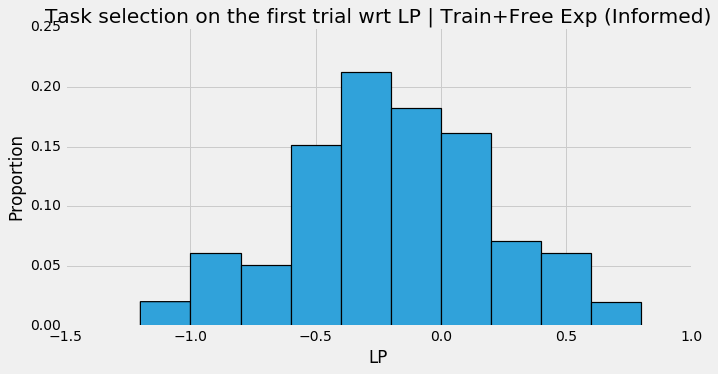

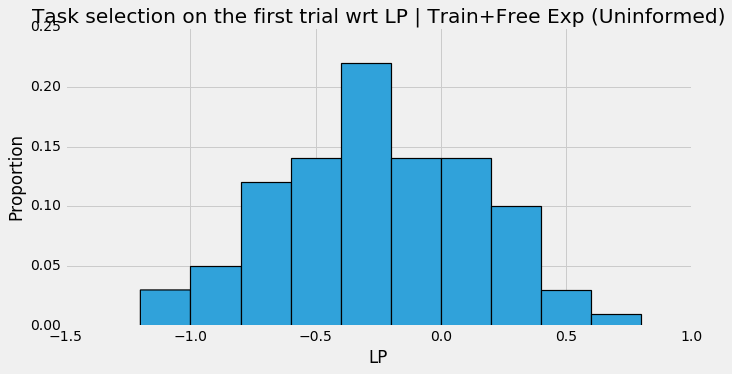

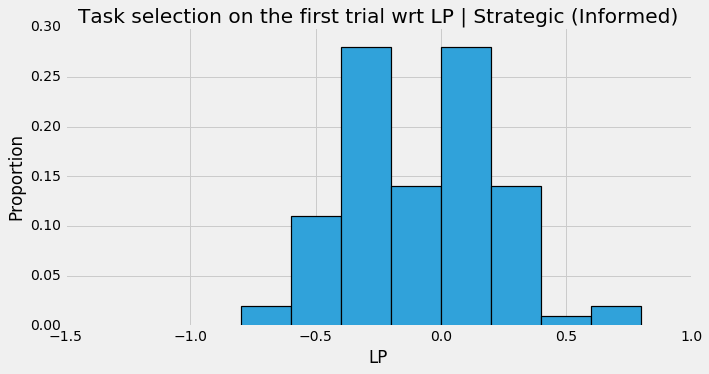

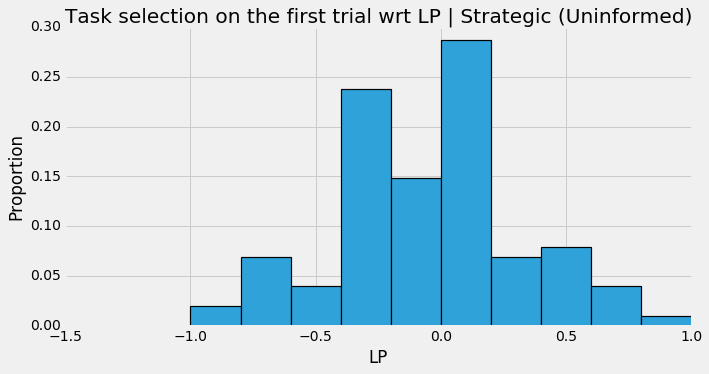

In [21]:
# Gets the p(correct) at each trial per task and per user
def extractSuccTrajec(arr, userArr):
    # Store p(correct) per user
    succUser = []
    # Go through user
    for u in range(userArr):
        tmpU = arr[u]
        # Init prior
        alpha,bet = 2,2
        # Store p(correct) = predicted accuracy evolution per task for user u
        succTask = []
        # Go through each task
        for t in range(tasks):
            # Split by task
            tmpT = tmpU[tmpU[:,1] == t]
            # Go through its trial history
            # store successes/errors in this task
            succ = []
            #print(np.mean(beta(alpha+succ, bet+(0+1)-succ).rvs(size=500)), alpha+succ, bet+0-succ)
            for trial in range(np.shape(tmpT)[0]):
                # Check if the answer was correct on this trial
                if tmpT[trial,2] == 1:
                    succ.append(0)
                else:
                    succ.append(1)
            succTask.append(succ)
        succUser.append(succTask)
    return np.asarray(succUser)

# Obtain predicted accuracy (e.g. "I predict based on my observations that my p(correct)=? if you ask me 
# to classify instances of this exercise without receiving any feedback")
succFTTI = extractSuccTrajec(splitInfFTT, usersFTI)
succFTTU = extractSuccTrajec(splitUniFTT, usersFTU)
succSTI = extractSuccTrajec(splitInfST, usersSI)
succSTU = extractSuccTrajec(splitUniST, usersSU)

def getLPBinary(probs, userArr):
    lpsUser = []
    # Go through every user and task
    for u in range(userArr):
        #tmpU = diff[u]
        tmpU = probs[u]
        lps = []
        for t in range(tasks):
            # Convert prob to errors
            errT = 1-tmpU[t]
            # fit polinomial to error differences
            slope, intercept = np.polyfit(np.arange(len(errT)), errT, 1)
            x = np.linspace(0, len(errT)-1, 100)
            # LP = - [Fitted Error(present) - Fitted Error(past)]
            lp = -((slope*x[-1]+intercept)-(slope*x[0]+intercept))
            lps.append(lp)
            #print(slope*x[0]+intercept, slope*x[-1]+intercept, diffT, lp)
            #print(probs[u], errT, diffT, slope*x[0]+intercept, slope*x[-1]+intercept, lp)
        lpsUser.append(lps)
        
        #print(lpsUser)
    return np.asarray(lpsUser)

# Get LP
lpFTTI_B = getLPBinary(succFTTI, usersFTI)
lpFTTU_B = getLPBinary(succFTTU, usersFTU)
lpSTI_B = getLPBinary(succSTI, usersSI)
lpSTU_B = getLPBinary(succSTU, usersSU)
#print(np.shape(lpFTTI), lpFTTI)

# Associate training LP to first selection
fslpFTI_B = lpFTTI_B[np.arange(len(lpFTTI_B)), selFTI[0]]
fslpFTU_B = lpFTTU_B[np.arange(len(lpFTTU_B)), selFTU[0]]
fslpSI_B = lpSTI_B[np.arange(len(lpSTI_B)), selSI[0]]
fslpSU_B = lpSTU_B[np.arange(len(lpSTU_B)), selSU[0]]

def plotLP(arr, label):
    
    #performance = checkPerformance(arr, firstSelec)
    # Create bins (0 - 0.03 in 0.001 steps)
    binsLP = np.arange(-1.2, 1.1, 0.2) 
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Normalize to sum 1
    weights = np.ones_like(arr)/len(arr)
    plt.hist(arr, bins=binsLP, weights=weights, edgecolor='black', linewidth=1.2)
    #plt.hist(arr, bins=binsLP, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt LP | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_xlabel('LP')
    #ax.set_ylim([0,0.37])
    
plotLP(fslpFTI_B, 'Train+Free Exp (Informed)')
plotLP(fslpFTU_B, 'Train+Free Exp (Uninformed)')
plotLP(fslpSI_B, 'Strategic (Informed)')
plotLP(fslpSU_B, 'Strategic (Uninformed)')

<a id='A7'></a>
## A7 - Relative Learning Progress

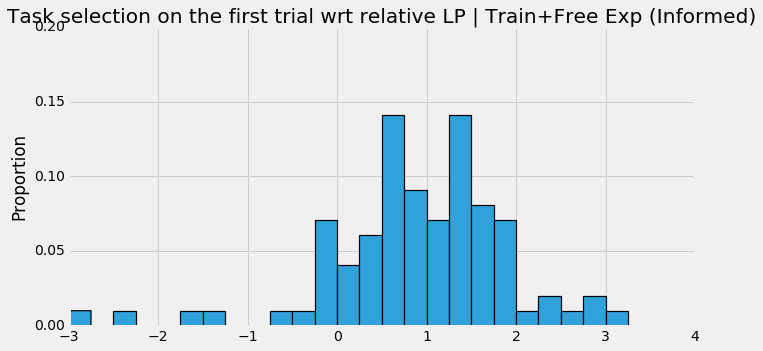

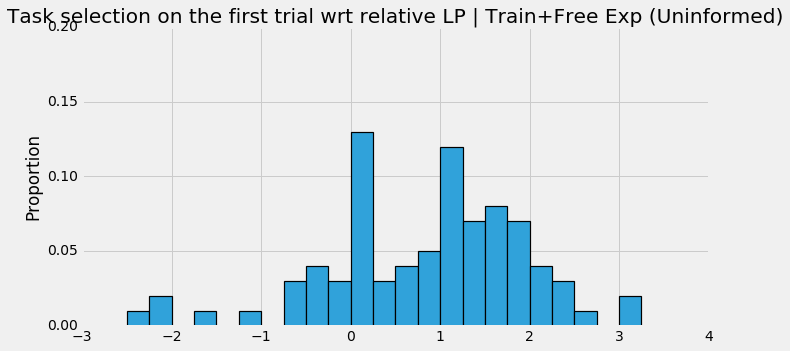

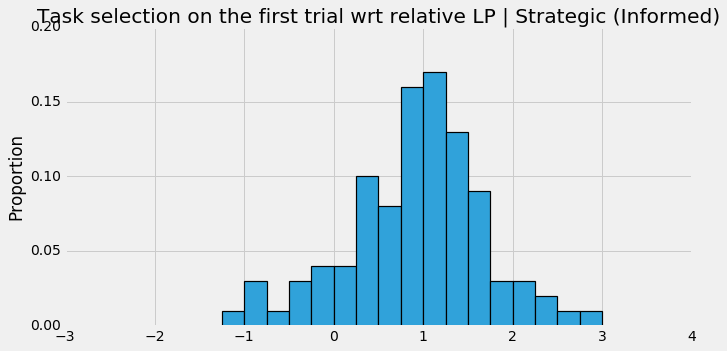

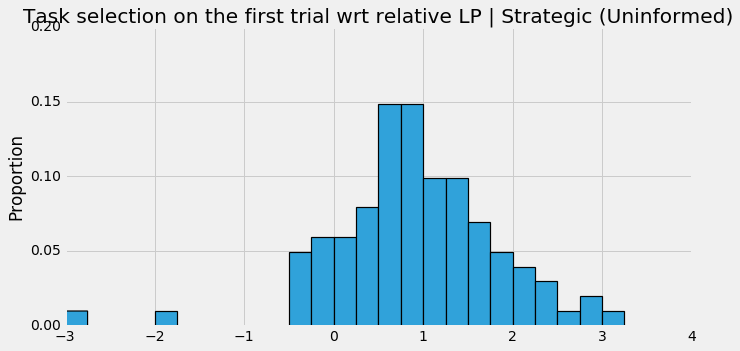

In [22]:
# Get relative training LP of the first task selected
def checkRelativeLP(lps, firstSelecLP):
    # Get average LP per user for the four tasks
    means = np.mean(lps, axis=1)
    # Normalize the LP of the task that was selected in relation to the mean
    normlp = firstSelecLP/means
    return normlp

def plotRelativeLP(arr, firstSelec, label, bin_min=-3.0, bin_max=3.3, bin_step=0.25):
    
    relLP = checkRelativeLP(arr, firstSelec)
    
    # Create bins (0 - 1 in 0.1 steps)
    #binsLP = np.linspace(0,2.1,22)
    binsLP = np.arange(bin_min, bin_max, bin_step) 
    
    fig, ax = plt.subplots(figsize=(10, 5))
    # Normalize to sum 1
    weights = np.ones_like(relLP)/len(relLP)
    #plt.hist(performance, bins=binsPC, weights=weights, edgecolor='black', linewidth=1.2)
    plt.hist(relLP, bins=binsLP, weights=weights, edgecolor='black', linewidth=1.2)
    
    #plt.hist(performance, bins=binsPC, edgecolor='black', linewidth=1.2)
    ax.set_title(''.join(['Task selection on the first trial wrt relative LP | ', label]))
    ax.set_ylabel('Proportion')
    ax.set_ylim([0,0.2])
    
plotRelativeLP(lpFTTI,fslpFTI, 'Train+Free Exp (Informed)')
plotRelativeLP(lpFTTU,fslpFTU, 'Train+Free Exp (Uninformed)')
plotRelativeLP(lpSTI,fslpSI, 'Strategic (Informed)')
plotRelativeLP(lpSTU,fslpSU, 'Strategic (Uninformed)')